<a href="https://colab.research.google.com/github/evgeny-kolonsky/Lab3_MW/blob/main/Lab3_MW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Lab 3  Mechanical Waves

Evgeny Kolonsky 2024

v.0.1.18 free right end

In [1]:
import numpy as np
from scipy import linalg as LA
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.signal import find_peaks

#Intro

![overview](https://raw.githubusercontent.com/evgeny-kolonsky/Lab3_MW/refs/heads/main/mech_waves_overview.png)


## Natural freqiencies

Motion equataion for a system of $n$ chained osciallators with viscous friction in matrix form is
$$
M \ddot x + B \dot x + K x = F(t)
$$
here $M$ - moment inertia matrix, $B$ - friction coefficients matrix, $K$ - angle elastity matrix, $x$ - coordinates (rotation angles) vector, F(t) - driving forces vector.

Coordinates vector $x$
$$
x =  \begin{bmatrix}
      x_1 \\
      \vdots\\
      x_n \end{bmatrix} ,
$$

Inertia matrix $M$
$$
M =  \begin{bmatrix}
      J_1 &     \\
       &\ddots & \\
       &            & J_n
      \end{bmatrix} ,
$$
Friction matrix $B$
$$
B =  \begin{bmatrix}
      2 b &  -b  &  &         \\
      -b  &  2b  & -b &          \\
         & -b   &   &  &         \\
      & & &\ddots & -b\\
      & &         & -b & 2 b
      \end{bmatrix}
$$
Elastity matrix $K$ for fixed right end and free right end respectively
$$
K_{\texttt{fix}} =  \begin{bmatrix}
      2 k &  -k  &  &         \\
      -k  &  2k  & -k &          \\
         & -k   &   &  &         \\
      & & &\ddots & -k\\
      & &         & -k & 2 k
      \end{bmatrix}
\qquad
K_{\texttt{free}} =  \begin{bmatrix}
      2 k &  -k  &  &         \\
      -k  &  2k  & -k &          \\
         & -k   &   &  &         \\
      & & &\ddots & -k\\
      & &         & -k &  k
      \end{bmatrix}
$$

If $E_i$ is eigenvectors  matrix and $\lambda_i$  are eigenvalues of matrix $Z = M^{-1}  K$, then natural frequecnies $\omega_i$ of the system are respective square roots of eigenvalues:
$$
\omega_i^2 = \lambda_i \quad i = 1,\cdots, n.
$$



In [41]:
# System parameters
# wide unit
l = 456e-3  # length of a bar
m = 43e-3   # mass of a bar
J = m * l**2 / 12 # moment of inertia of a bar
n = 72  # number of bars in the oscillation system

k = 1.02 # elastity coeff

K = k * (np.diag(np.ones(n) * 2, 0) + \
    np.diag(-np.ones(n-1)   , 1) +  \
    np.diag(-np.ones(n-1)   ,-1))

K[-1, -1] = k # free end

M = np.eye(n) * J

Q = 10 # quality factor
b =  np.sqrt(J*k) / Q # approx. friction coefficent (at least by order value)

B = b * (np.diag(np.ones(n) * 2, 0) + \
    np.diag(-np.ones(n-1)   , 1) +  \
    np.diag(-np.ones(n-1)   ,-1))

Km  =  LA.inv(M) @ K
Bm  =  LA.inv(M) @ B

zeros = np.zeros((n,n))
I     = np.eye(n)

D = np.vstack([np.hstack([zeros,  I]),
               np.hstack([-Km,   -Bm])] \
             )
F = np.zeros(n)
F2 = np.hstack([np.zeros(n), F])

lambdas, E = LA.eig(Km)
ix = np.argsort(lambdas)
lambdas = lambdas[ix]
E = E[:, ix]
omega = np.sqrt(lambdas)

freqs = np.real(omega) / 2 / np.pi

print(f'Natural frequencies from {np.min(freqs):.3f} Hz to {np.max(freqs):.3f} Hz')

Natural frequencies from 0.128 Hz to 11.774 Hz


## Berkeley 3 correction


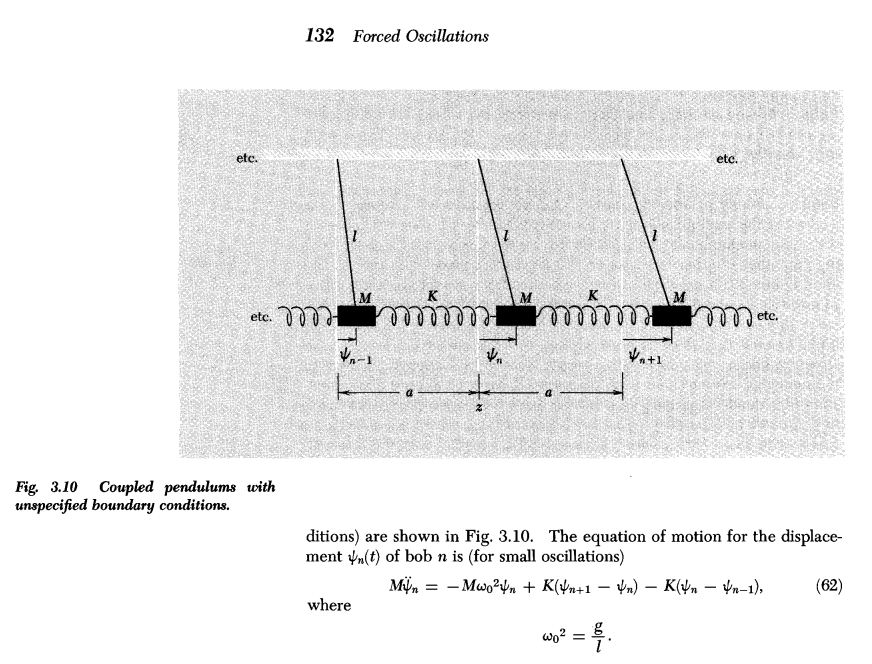

In [42]:
# oscillatons freq of system as a whole
# See Berkeley 3 - Series of oscillators
# omega0_2 = g/l
omega0 = 2 # Hz - just to test
K += J * omega0**2 * np.diag(np.ones(n))

Km  =  LA.inv(M) @ K

D = np.vstack([np.hstack([zeros,  I]),
               np.hstack([-Km,   -Bm])] \
             )

lambdas, E = LA.eig(Km)
ix = np.argsort(lambdas)
lambdas = lambdas[ix]
E = E[:, ix]
omega = np.sqrt(lambdas)

freqs = np.real(omega) / 2 / np.pi

print(f'Natural frequencies from {np.min(freqs):.3f} Hz to {np.max(freqs):.3f} Hz')

Natural frequencies from 0.343 Hz to 11.779 Hz


# Amplitude response

Equation for forced oscillations with friction
\begin{equation}
    M \ddot X(t) + B\dot X(t) + K X(t) = F e^{i \omega t}
\end{equation}

Model equations for steady-state solution are:
\begin{equation}
    X(t) = C e^{i \omega t},
\end{equation}
where $C$ is vector of complex amplitudes:
\begin{equation}
    C =  \begin{bmatrix} C_1 \\ \vdots \\C_n \end{bmatrix}.
\end{equation}

Substitute steady-state solution to motion equation to find $C$:
\begin{equation}
(-\omega^2 M + i \omega B + K) \times C = F
\end{equation}
Let
\begin{equation}
    Z =  -\omega^2 M + i \omega B + K.
\end{equation}


Relative amplitudes response
\begin{equation}
\frac{C}{\eta_0} =  Z^{-1} \frac{F}{\eta_0}
\end{equation}






(0.1, 2.0)

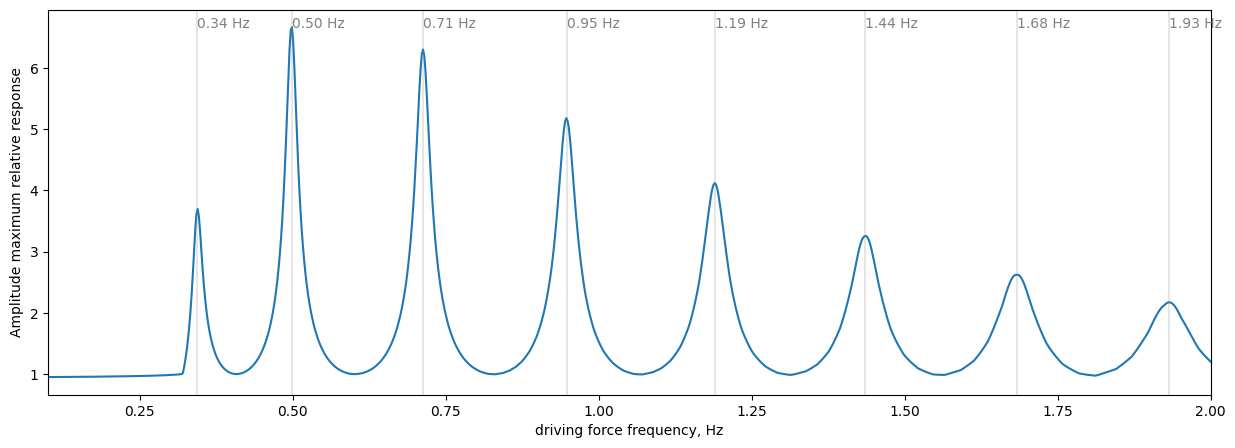

In [43]:
def amplitude(omega_external):
  Z = -omega_external**2 * M + 1j * omega_external * B + K
  F = np.zeros(n)
  F[0] = k
  C = LA.inv(Z) @ F
  return C

MAX_FREQ = 2 #Hz
omegas = np.linspace(0.0, MAX_FREQ * 2 * np.pi, 1000)
response = [np.max(np.abs(amplitude(omega))) for omega in omegas]

plt.figure(figsize=(15, 5))
plt.plot(omegas/2/np.pi, response)
plt.xlabel('driving force frequency, Hz')
plt.ylabel('Amplitude maximum relative response')
for freq in freqs:
  plt.axvline(freq, color='gray', linestyle='-', alpha=0.2)
  plt.annotate(f'{freq:.2f} Hz', xy=(freq, np.max(response)), color='gray')
plt.xlim(0.1, MAX_FREQ)



## Normal modes

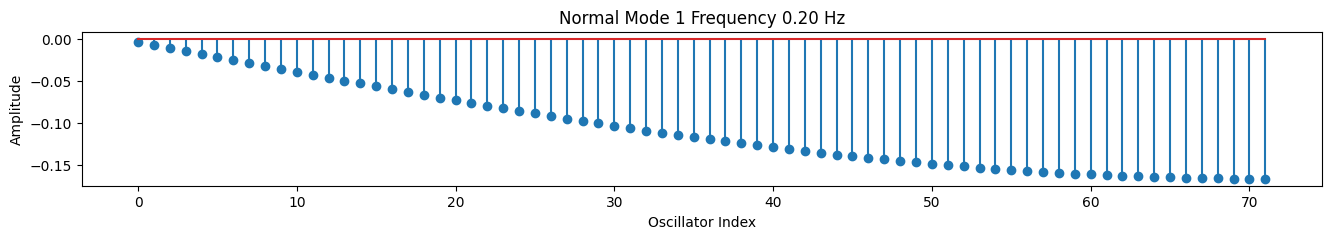

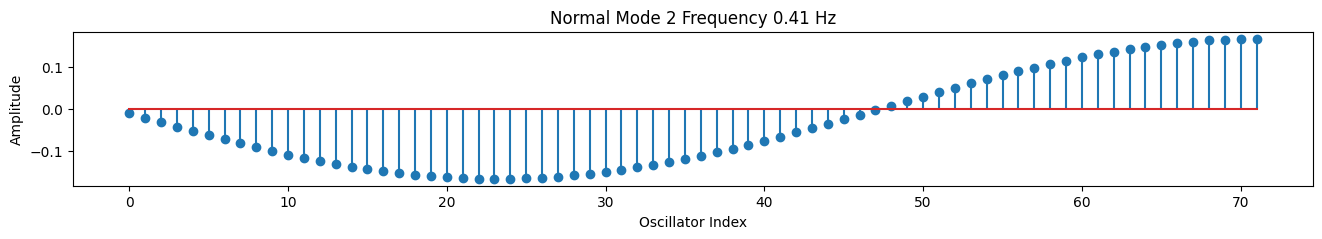

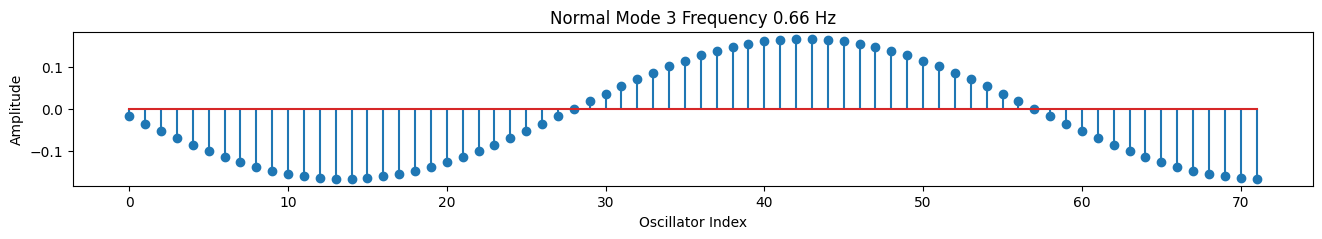

In [22]:
lambdas, E = LA.eig(Km)
ix = np.argsort(lambdas)
lambdas = lambdas[ix]
E = E[:, ix]
omega = np.sqrt(lambdas)

freqs = np.real(omega) / 2 / np.pi

# Plotting few first  normal modes
for i in range(3):
    plt.figure(figsize=(16, 2))
    plt.stem(E[:, i].real, '.')  # Plotting the real part of the eigenvector
    plt.title(f"Normal Mode {i+1} Frequency {freqs[i]:.2f} Hz")
    plt.xlabel("Oscillator Index")
    plt.ylabel("Amplitude")
    plt.show()

**Wave propagation** constant

$$
\beta =  \sqrt{\frac{k}{J}}
$$

In [23]:
# the mechanical wave system
L = 920e-3 # length of the system
d = 1.27e-2  # m,distance between bars

beta = np.sqrt(k/J)
v = d * beta

print(f'wave velocity expected {v*100:.0f} cm/s, {beta:.0f} bar/s')

wave velocity expected 47 cm/s, 37 bar/s


Define **external force** profile

In [13]:
# External harmonic force
freq_external = 0.13 # Hz
eta0 = 0.2 # radian    displacement amplitude
print(f'external force frequency {freq_external:.2f} Hz')

# initial beat at the right end
eta = lambda t: np.sin(2*np.pi*freq_external*t) * eta0  #if t < 1/freq_external/2 else 0
#eta = lambda t:  eta0  if t < 0.1 else 0

external force frequency 0.13 Hz



**Numerical solution**

We set up new **state variable** $z$:
$$
z =  [ x_1, \cdots x_n, \, \dot x_1, \cdots, \dot x_n ] = [x, \dot x]
$$
and it's derivative
$$
\dot z =  [ \dot x, \ddot x ].
$$

The motion equation becomes state equation:
$$
\dot z =
\begin{bmatrix}
\dot x\\
\ddot x
\end{bmatrix}
 =
\begin{bmatrix}
0 & 1\\
-M^{-1}K & 0
\end{bmatrix}
\begin{bmatrix}
x\\
\dot x
\end{bmatrix}
$$
for no-friction no-forces case. Here $0$ and $1$ are zero and identity matricies respectively.

The state equation with viscous friction and external forces will be
$$
\dot z =
\begin{bmatrix}
0 & 1\\
-M^{-1}K & -M^{-1}B
\end{bmatrix}
z
+
\begin{bmatrix}
0 \\
M^{-1} F
\end{bmatrix}
\tag{1}
$$

State equation (1) enables iterative numerical solution by [Heun method](https://en.wikipedia.org/wiki/Heun%27s_method).


In [14]:
def state_derivative(state, time):
  # state - array of x1 .. xn, v1.. vn
  # x - coordinates and v - corresponding velocities
  # ti - point of time. External force depends on time
  zdot = D @ state
  F2[n] = k * eta(time) / J  # applied only at leftmost point
  zdot += F2
  return zdot

def heun_step(state, time, dt,etol=0.000001,maxiters = 100):
    '''Update a state to the next time increment using the implicit Heun's method.

    Arguments
    ---------
    state : array of dependent variables
    dt    : float, time increment
    etol  : tolerance in error for each time step corrector
    maxiters: maximum number of iterations each time step can take

    Returns
    -------
    next_state : array, updated after one time increment'''
    e = 1
    eps = np.finfo('float64').eps
    next_state = state + state_derivative(state, time) * dt
    ################### New iterative correction #########################
    for n in range(0, maxiters):
        next_state_old = next_state
        next_state = state + (state_derivative(state, time) + state_derivative(next_state, time))/2*dt
        e = np.sum(np.abs(next_state-next_state_old) / np.abs(next_state+eps))
        if e < etol:
            break
    ############### end of iterative correction #########################
    return next_state


# Integrate numerically

In [15]:
T = 4 * L / v # time to travel there and back again twice
dt = 1 / np.max(freqs) / 4 # shortest period / 4


t = np.arange(0, T, dt)
N = len(t)  # steps in time
print(f'Integrate for {N} steps {T:.1f} s')


def integrate():
  state = np.zeros((2 * n, N))

  for i in range(0, N-1):
      state[:,i+1] = heun_step(state[:,i], t[i], dt)
  return state

state = integrate()


Integrate for 369 steps 7.8 s


**Animate**

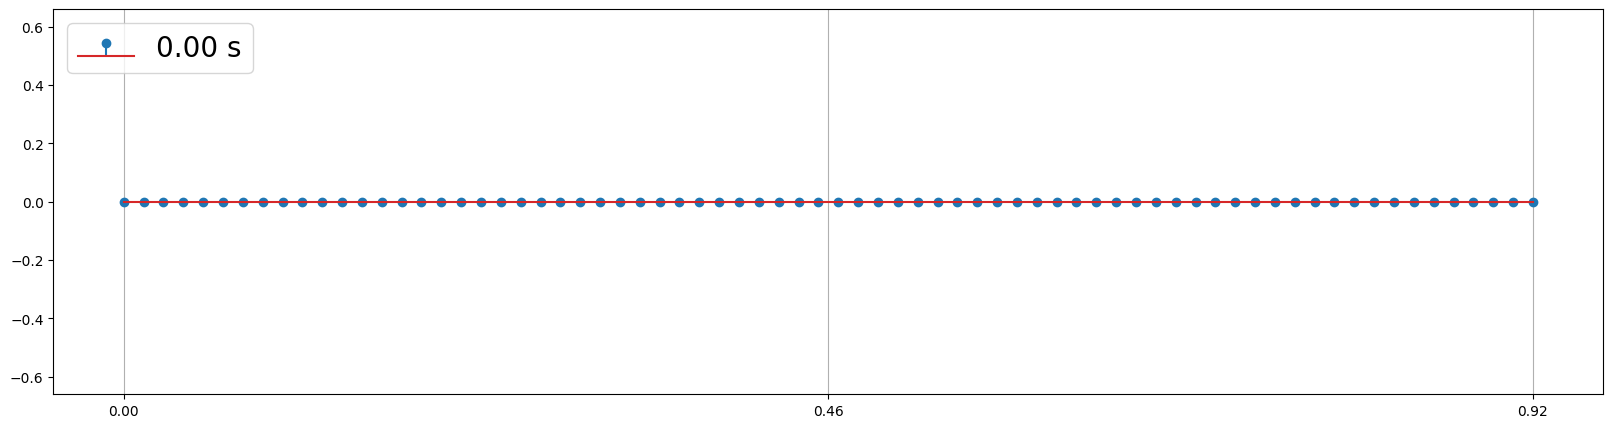

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))
x = np.linspace(0, L, n)
y = np.copy(state[:n, 0])
y[0] = 3.0 * eta0 # vertical scale
y[-1] = - y[0]
bottom = 0
h_stem = ax.stem(x, y, bottom=bottom,  linefmt='-', markerfmt='o', label='Time');
legend = ax.legend(fontsize="20", loc ="upper left") #Define legend objects
ax.grid(axis='x')
ax.set_xticks([0, L/2, L])

def update(i):
    y = state[:n, i]

    # markerline
    h_stem[0].set_ydata(y)
    #h_stem[0].set_xdata(x)  # not necessary for constant x

    # stemlines
    h_stem[1].set_paths([np.array([[xx, bottom],
                                   [xx, yy]]) for (xx, yy) in zip(x, y)])

    # baseline
    h_stem[2].set_xdata([np.min(x), np.max(x)])
    #h_stem[2].set_ydata([bottom, bottom])  # not necessary for constant bottom
    legend.get_texts()[0].set_text(f'{t[i]:.2f} s') #Update label each at frame

anim = FuncAnimation(fig, update, frames=range(0, N,2), interval=2*dt)
anim.save('so.gif', dpi=80)

# Peaks analysis

Plot peaks development in time

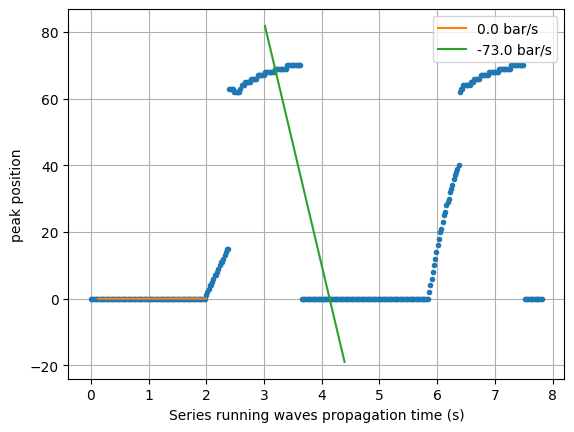

In [17]:
from scipy.stats import linregress

right_peaks = []
for i, time in enumerate(t):
  y = state[:n, i]
  peaks, _ = find_peaks(np.sqrt(y*y), height=0.1)
  if len(peaks) > 0:
    right_peaks.append(np.max(peaks))
  else:
    right_peaks.append(0)

right_peaks = np.array(right_peaks)
plt.plot(t, right_peaks,'.')

plt.xlabel('Series running waves propagation time (s)')
plt.ylabel('peak position')

mask = (t > 0.12) & (t<2)
# Convert the boolean mask to integer indices
# Use the integer indices to select elements from right_peaks
fit = linregress(t[mask], right_peaks[mask])
plt.plot(t[mask], fit.slope * t[mask] + fit.intercept, label=f'{fit.slope:.1f} bar/s')

mask = (t > 3.0) & (t<4.4)
# Convert the boolean mask to integer indices
# Use the integer indices to select elements from right_peaks
fit = linregress(t[mask], right_peaks[mask])
plt.plot(t[mask], fit.slope * t[mask] + fit.intercept, label=f'{fit.slope:.1f} bar/s')

plt.legend()

#plt.xlim(0.3,1)
#plt.ylim(0,30)
plt.grid()

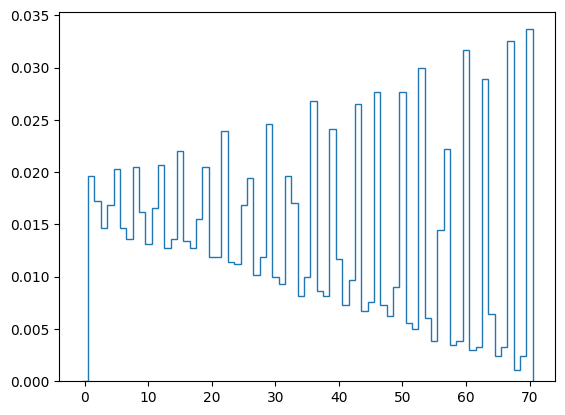

In [ ]:
def get_peaks(state):
  right_peaks = np.array([])
  for i, time in enumerate(t):
    y = state[:n, i]  # focus on right half, far from actuator
    peaks, _ = find_peaks(np.sqrt(y*y), height=0.1)
    if len(peaks) > 0:
      right_peaks = np.hstack([right_peaks, peaks])
  return right_peaks

freq_external = 5
state = integrate()
p = get_peaks(state)
plt.hist(p, histtype='step', bins=np.arange(0,n)-0.5, density=True);


**References**

Charles G. Torre
Department of Physics, Utah State University
04 Linear Chain of Coupled Oscillators [.pdf](https://digitalcommons.usu.edu/foundation_wave/19/)


Computational Mechanics 5 - Good Vibrations [.ipynb](https://cooperrc.github.io/computational-mechanics/module_05/03_Good_Vibrations.html#./02_Keep_it_steady.ipynb)

In [ ]:
for order in range(5, 19, 2):
  print(f'{order=} f ={order * v /  4 / L:.2f}') # Hz, displacement frequency


order=5 f =0.64
order=7 f =0.89
order=9 f =1.15
order=11 f =1.40
order=13 f =1.66
order=15 f =1.92
order=17 f =2.17
